<a href="https://colab.research.google.com/github/mariskaiz/TugasML/blob/main/ML2_Kel_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, BatchNormalization, Embedding, LSTM
from keras.metrics import Accuracy
from keras import utils
from keras import callbacks
from sklearn.model_selection import train_test_split
from absl import logging

#ignore notification
logging.set_verbosity(logging.ERROR)

In [20]:
# Loading data
df = pd.read_csv('/content/SPAM text message 20170820 - Data.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [21]:
#pemrosesan label objek menjadi biner
print(f'Number of objects in the dataset: {df.shape[0]}')

label_type = list(df['Category'].unique())
print(f'Types of labels in the dataset: {label_type}')

# ham: 0 , spam : 1
df.replace('ham', 0, inplace=True)
df.replace('spam', 1, inplace=True)
df['Category'] = df['Category'].astype('int8')

Number of objects in the dataset: 5572
Types of labels in the dataset: ['ham', 'spam']


In [22]:
df

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [23]:
#visualisasi jumlah ham dan spam
groups = df.groupby(by='Category').count().Message
CNT_HAM = groups[0]
CNT_SPAM = groups[1]
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Ham', 'Spam'],
    y=[CNT_HAM, CNT_SPAM],
    marker_color='indianred',
    width=[0.4, 0.4]))

fig.update_layout(title='Classes and their number in the dataset', title_x=0.5)

In [24]:
texts = df['Message']
labels = df['Category']

NUM_WORDS = 10000
MAX_TEXT_LEN = 100

#training untuk tokenisasi
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(texts)

# menampilkan hasil tokenisasi
word_count = 50
keys = list(tokenizer.word_index.keys())[:word_count]
values = list(tokenizer.word_index.values())[:word_count]
list(zip(keys, values))

[('i', 1),
 ('to', 2),
 ('you', 3),
 ('a', 4),
 ('the', 5),
 ('u', 6),
 ('and', 7),
 ('in', 8),
 ('is', 9),
 ('me', 10),
 ('my', 11),
 ('for', 12),
 ('your', 13),
 ('it', 14),
 ('of', 15),
 ('call', 16),
 ('have', 17),
 ('on', 18),
 ('2', 19),
 ('that', 20),
 ('now', 21),
 ('are', 22),
 ('so', 23),
 ('but', 24),
 ('not', 25),
 ('or', 26),
 ('do', 27),
 ('can', 28),
 ('at', 29),
 ("i'm", 30),
 ('ur', 31),
 ('get', 32),
 ('will', 33),
 ('if', 34),
 ('be', 35),
 ('with', 36),
 ('just', 37),
 ('no', 38),
 ('we', 39),
 ('this', 40),
 ('4', 41),
 ('gt', 42),
 ('lt', 43),
 ('up', 44),
 ('when', 45),
 ('ok', 46),
 ('free', 47),
 ('from', 48),
 ('go', 49),
 ('how', 50)]

In [25]:
sequences = tokenizer.texts_to_sequences(texts)

# As a result, the text under the following index was converted to a vector
index = 6
print(texts[index])
print(sequences[index])

X = pad_sequences(sequences, maxlen=MAX_TEXT_LEN)  # Standardization of the number of elements in a vector
y = labels.copy()

Even my brother is not like to speak with me. They treat me like aids patent.
[210, 11, 633, 9, 25, 55, 2, 382, 36, 10, 110, 718, 10, 55, 4429, 4430]


In [26]:
sequences_len = []
for sequence in sequences:
    seq_len = len(sequence)
    sequences_len.append(seq_len)

fig = go.Figure(data=[go.Histogram(x=sequences_len, marker_color='indianred')])
fig.update_layout(title='Histogram of the length of texts', title_x=0.5,xaxis_title="Text length",
                  yaxis_title="Count")

In [27]:
# Separation of data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print(f'Training sample size: {len(X_train)}')
print(f'Test sample size: {len(X_test)}')

Training sample size: 4457
Test sample size: 1115


In [28]:
#pembuatan dan pelatihan reccurent model (LSTM)
model = Sequential()
model.add(Embedding(NUM_WORDS, 64, input_length=MAX_TEXT_LEN))
model.add(LSTM(3, return_sequences=True))
model.add(LSTM(5, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(12))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [29]:
callbacks = [
    EarlyStopping(monitor='loss', min_delta=0.01, patience=10, verbose=1),
    ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=4, verbose=1, mode='auto')
]

model.compile(metrics=['accuracy'], loss='binary_crossentropy', optimizer='Adam')

history = model.fit(X_train, y_train, batch_size=50, epochs=10, validation_split=0.2,  callbacks=callbacks)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.8495 - loss: 0.4591 - val_accuracy: 0.8576 - val_loss: 0.5375 - learning_rate: 0.0010
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.9765 - loss: 0.1650 - val_accuracy: 0.8643 - val_loss: 0.3423 - learning_rate: 0.0010
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.9945 - loss: 0.0697 - val_accuracy: 0.9652 - val_loss: 0.2219 - learning_rate: 0.0010
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.9977 - loss: 0.0404 - val_accuracy: 0.9843 - val_loss: 0.1498 - learning_rate: 0.0010
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.9998 - loss: 0.0223 - val_accuracy: 0.9843 - val_loss: 0.0945 - learning_rate: 0.0010
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 0.0146 - val_accuracy: 0.9821 - val_loss: 0.0763 - learning_rate: 0.0010
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.9999 - loss: 0.0102

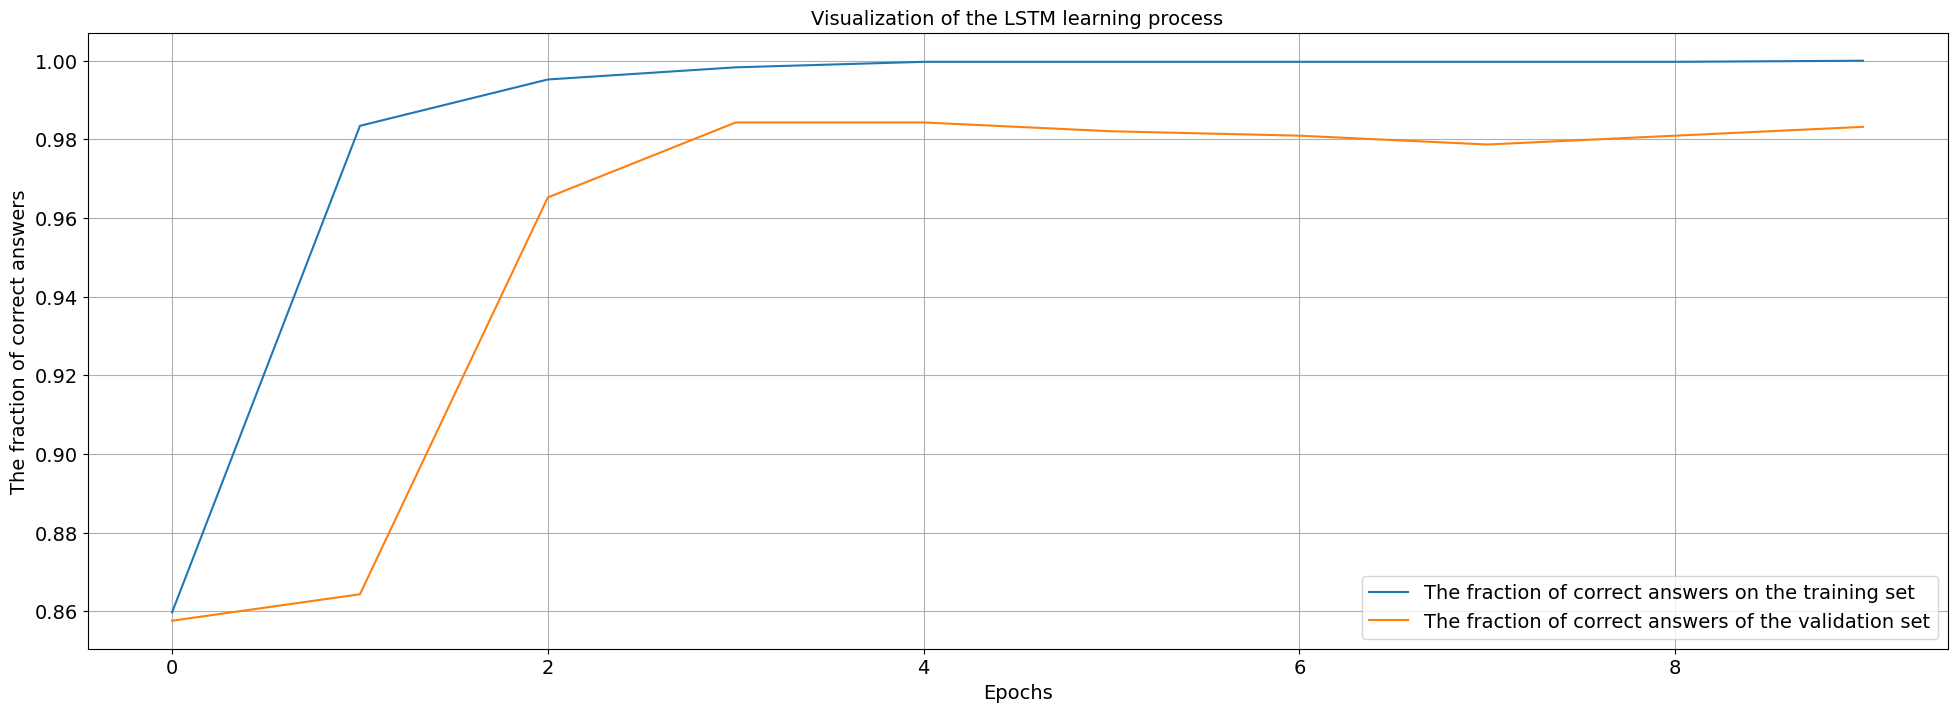

In [31]:
plt.figure(figsize=(24, 8))
plt.title('Visualization of the LSTM learning process', fontsize=14)
plt.plot(history.history['accuracy'], label='The fraction of correct answers on the training set')
plt.plot(history.history['val_accuracy'], label='The fraction of correct answers of the validation set')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('The fraction of correct answers', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=14)
plt.show()


In [32]:
print(f'Metric on test: {model.evaluate(X_test, y_test)}')
print(f'Metric on train: {model.evaluate(X_train, y_train)}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9868 - loss: 0.0654
Metric on test: [0.05931973457336426, 0.9865471124649048]
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9994 - loss: 0.0068
Metric on train: [0.02029775083065033, 0.9964101314544678]


In [33]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 100, 3)              │             816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 100, 5)              │             180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100, 5)              │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 12)                  │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,925,661 (7.35 MB)

 Trainable params: 641,883 (2.45 MB)

 Non-trainable params: 10 (40.00 B)

 Optimizer params: 1,283,768 (4.90 MB)

In [34]:
def ml_pipeline(text: str) -> str:
    """LSTM model prediction function for this sample"""
    try:
        sequence = tokenizer.texts_to_sequences([text])
        sequence = pad_sequences(sequence, maxlen=MAX_TEXT_LEN)
        if sequence.max() == 0:
            return 'Enter the words in English'
        else:
            predict = model.predict(sequence, verbose=0)
            if predict > 0.5:
                return 'The text is spam'
            else:
                return 'The text is not spam'
    except AttributeError:
        return 'Enter the text'

In [35]:
#percobaan input pesan
ml_pipeline('I love Science!!!')

'The text is not spam'